In [130]:
import pandas as pd

from sklearn import metrics
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS

In [131]:
#Importing Data
df = pd.read_csv('./data/comment_data_oct_nov.csv')

In [132]:
# Calculating Baseline
y.value_counts(normalize = True)

0    0.501218
1    0.498782
Name: subreddit, dtype: float64

In [133]:
# Creating X and y and train test split
X = df['body']
y = df['subreddit'].map({'nfl': 0, 'fantasyfootball': 1})
X_train, X_test, y_train, y_test = train_test_split(X,  y, test_size = .2, random_state = 123, stratify = y)

In [134]:
# Function to replace numbers
def replace_number(X):
    return X.str.replace('\d{2,}', ' ANUMBER ')
replace_number_tf = FunctionTransformer(replace_number, validate = False)

In [135]:
# Function to replace tab and new line
def filler_chars(X):
    return X.str.replace('\n', ' ').replace('\t', ' ')
filler_chars_tf = FunctionTransformer(filler_chars, validate = False)

In [137]:
# Pipeline and gridsearch to optimize model
pipe = Pipeline([
    ('replace_number_tf', replace_number_tf),
    ('filler_chars_tf', filler_chars_tf),
    ('vect', TfidfVectorizer(binary=True, strip_accents = 'ascii', stop_words = ENGLISH_STOP_WORDS.union(['nfl', 'fantasy','football']))),
    ('model', RandomForestClassifier(class_weight = 'balanced', random_state = 42))
])

grid = {
    'vect__min_df': [1,2],
    'vect__max_df': [.3, .5],
    'vect__max_features': [1000, 2000],
    'model__max_depth':[1, 10],
    'model__n_estimators': [300, 500],
    'model__max_features': [5, 10]
}

gs = GridSearchCV(pipe, param_grid = grid)
gs.fit(X_train, y_train)
print(gs.best_score_) # cross val score
gs.best_params_

0.6962324253015068


{'model__max_depth': 10,
 'model__max_features': 5,
 'model__n_estimators': 500,
 'vect__max_df': 0.3,
 'vect__max_features': 2000,
 'vect__min_df': 2}

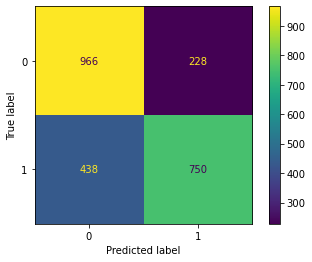

In [138]:
# Confusion matrix of the test data
metrics.plot_confusion_matrix(gs, X_test, y_test);

In [139]:
# Calculating Accuracy
(750 + 966)/(750 + 966 + 438 + 228)

0.7204030226700252

In [140]:
# Calculating test Recall
750/ (750 + 438)

0.6313131313131313

**Conclusions:** This model performs well. It has the highest accuracy of any of my models of 72%. Though the accuracy is great, I will be using my Logistic Regression model because it has a higher recall. Because I am attempting to target advertising, I want to make sure my model misses as few potential customers as possible. The Logistic Regression's 4% better recall is more important to me than the Random Forest's 1% better accuracy.